In [18]:
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [19]:
#Load the data
stokes = fits.open('/home/milic/data/Hinode_network/hinode_network_c.fits')[0].data

In [45]:
qs = np.mean(stokes[:,:,0,:10])
stokes /= qs
stokes.shape

(512, 873, 4, 112)

In [21]:
# Let's also assign wavelengths:
ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215
regions = [[ll, None]]
lines   = [6301, 6302]
# so now our code has wavelength grid and knows what to do

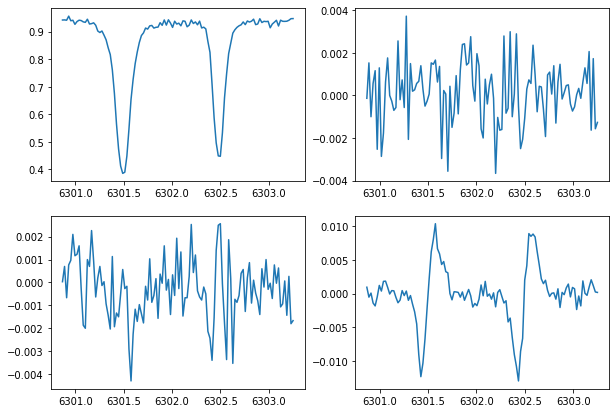

In [22]:
i=100
j=200
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,stokes[i,j,0])
plt.subplot(222)
plt.plot(ll,stokes[i,j,1])
plt.subplot(223)
plt.plot(ll,stokes[i,j,2])
plt.subplot(224)
plt.plot(ll,stokes[i,j,3])

In [27]:
#initialize the methods:
me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

In [28]:
# set up noise etc
noise_level = 1.e-3
sig = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
sig += noise_level
sig[0] *= 10. #noise is larger for I, because of systematics

In [30]:
nx = 1
ny = 1
iGuessed = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
guessed_initial  = me.repeat_model(iGuessed, ny, nx)
to_fit = stokes[i,j].reshape(1,1,4,112)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(guessed_initial, to_fit, sig, nRandom = 5, nIter=20, chi2_thres=1.0, verbose=False)


[[2.09358044]]


pyMilne::dealloc: cleaning-up...


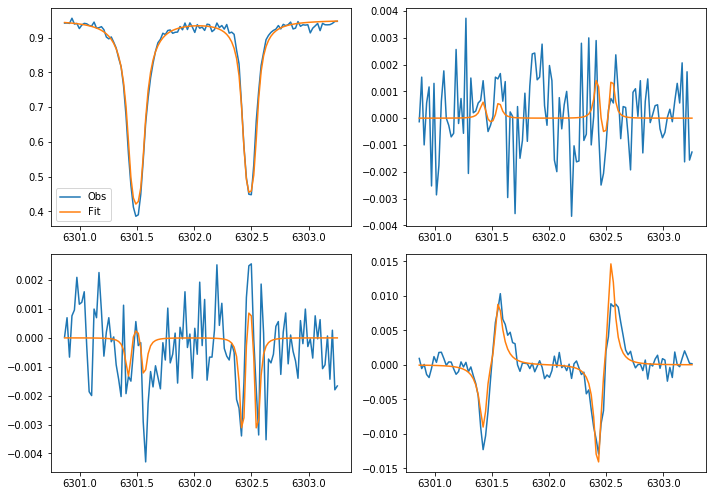

In [35]:
#test the plot
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,to_fit[0,0,0],label='Obs')
plt.plot(ll,syn_out[0,0,0],label='Fit')
plt.legend()
plt.subplot(222)
plt.plot(ll,to_fit[0,0,1],label='Obs')
plt.plot(ll,syn_out[0,0,1],label='Fit')
plt.subplot(223)
plt.plot(ll,to_fit[0,0,2],label='Obs')
plt.plot(ll,syn_out[0,0,2],label='Fit')
plt.subplot(224)
plt.plot(ll,to_fit[0,0,3],label='Obs')
plt.plot(ll,syn_out[0,0,3],label='Fit')
plt.tight_layout()

In [36]:
# Now we will try the same but for a chunk of pixels, re-alloc something:
me = MilneEddington.MilneEddington(regions, lines, nthreads=4)

pyMilne::dealloc: cleaning-up...


In [51]:
%%time
i = 0
j = 0
nx = 200
ny = 200
iGuessed = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
guessed_initial  = me.repeat_model(iGuessed, ny, nx)
to_fit = stokes[i:i+nx,j:j+ny].reshape(nx,ny,4,112)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(guessed_initial, to_fit, sig, nRandom = 5, nIter=20, chi2_thres=1.0, verbose=False)

CPU times: user 5min 11s, sys: 407 ms, total: 5min 11s
Wall time: 1min 18s


In [41]:
print(chi2)

[[ 2.31646633  2.98354104  2.93497518 ...  5.02945676  4.19570223
   6.77647415]
 [ 2.36828246  2.41528522  3.05308563 ...  4.5686126   4.78855606
  12.18747345]
 [ 2.16687186  2.37143403  2.58337066 ...  5.08764645  5.91660975
   7.4427957 ]
 ...
 [ 1.36851369  1.50412549  1.52664516 ...  6.37428025  6.90769127
  18.27387824]
 [ 1.56243186  1.2401028   1.39171642 ...  4.12066723  6.05591944
   7.50246364]
 [ 1.50770627  1.67010432  1.67758524 ...  2.55586035  6.15386272
   8.0426036 ]]


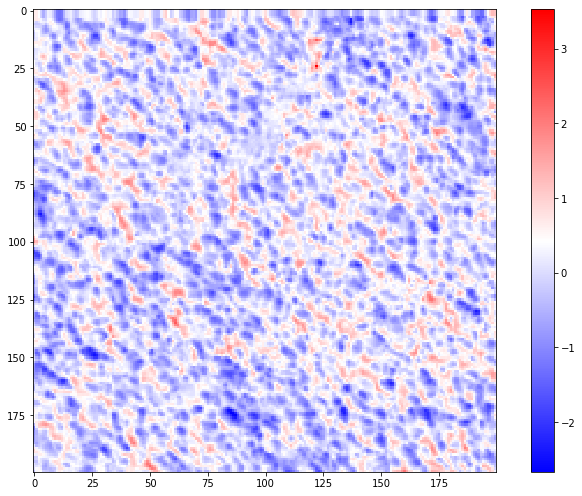

In [52]:
# Numbers look good, now let's try and plot some parameter maps:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,3]-np.mean(model_out[:,:,3]),cmap='bwr')
plt.colorbar()
plt.tight_layout()

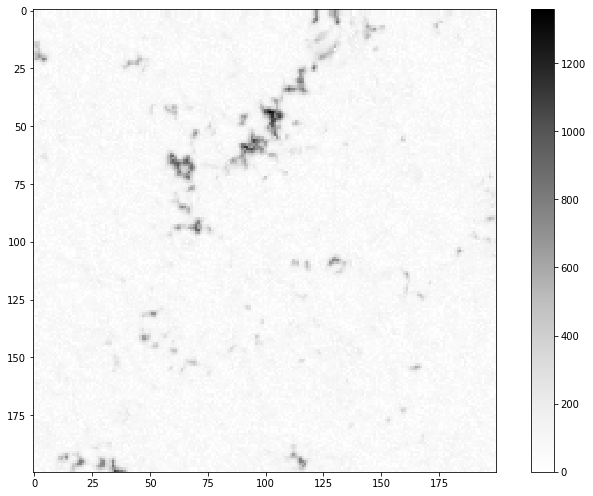

In [53]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,0],cmap='Greys')
plt.colorbar()
plt.tight_layout()